Dataset ready
Epoch 1, Loss: 0.7252
Epoch 2, Loss: 0.6270
Epoch 3, Loss: 0.3075
Epoch 4, Loss: 0.0210
Epoch 5, Loss: 0.0167
Epoch 6, Loss: 0.0200
Epoch 7, Loss: 0.0192
Epoch 8, Loss: 0.0149


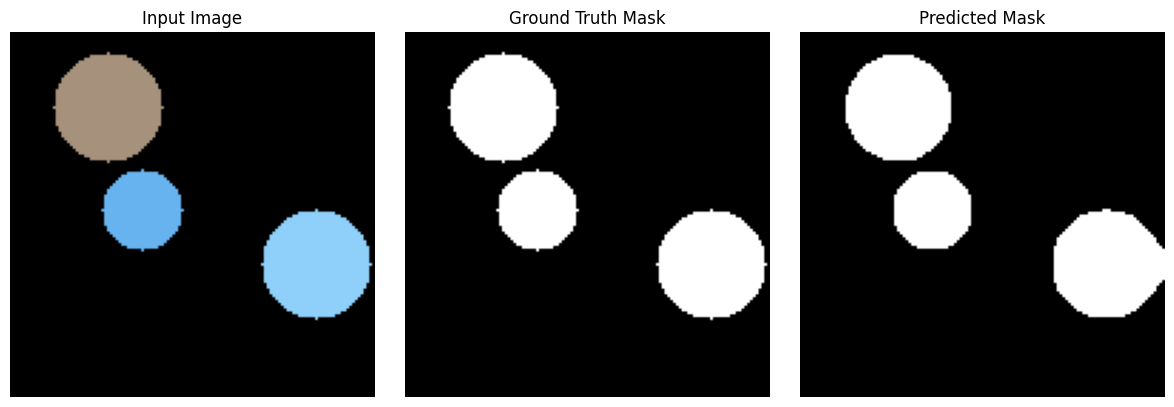

In [1]:
import os, cv2, torch, random, numpy as np, matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ===================== STEP 1: GENERATE DATASET =====================
os.makedirs("dataset/images", exist_ok=True)
os.makedirs("dataset/masks", exist_ok=True)

def random_shape(img, mask):
    h, w = img.shape[:2]
    shape = random.choice(["circle", "rectangle"])
    color = [random.randint(100,255) for _ in range(3)]

    if shape == "circle":
        center = (random.randint(20,w-20), random.randint(20,h-20))
        radius = random.randint(10,30)
        cv2.circle(img, center, radius, color, -1)
        cv2.circle(mask, center, radius, 255, -1)
    else:
        x1, y1 = random.randint(0,w-40), random.randint(0,h-40)
        x2, y2 = x1+random.randint(20,40), y1+random.randint(20,40)
        cv2.rectangle(img, (x1,y1), (x2,y2), color, -1)
        cv2.rectangle(mask, (x1,y1), (x2,y2), 255, -1)

for i in range(40):
    img = np.zeros((128,128,3), dtype=np.uint8)
    mask = np.zeros((128,128), dtype=np.uint8)
    for _ in range(random.randint(1,3)):
        random_shape(img, mask)
    cv2.imwrite(f"dataset/images/img_{i}.png", img)
    cv2.imwrite(f"dataset/masks/img_{i}.png", mask)

print("Dataset ready")

# ===================== STEP 2: DATASET LOADER =====================
class SegDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.imgs = os.listdir(img_dir)
        self.img_dir = img_dir
        self.mask_dir = mask_dir

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(self.img_dir, self.imgs[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.0
        img = torch.tensor(img).permute(2,0,1).float()

        mask = cv2.imread(os.path.join(self.mask_dir, self.imgs[idx]),0)
        mask = (mask/255).astype('uint8')
        mask = torch.tensor(mask).long()

        return img, mask

dataset = SegDataset('dataset/images','dataset/masks')
loader = DataLoader(dataset, batch_size=8, shuffle=True)

# ===================== STEP 3: MINI U-NET =====================
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c,out_c,3,padding=1), nn.ReLU(),
            nn.Conv2d(out_c,out_c,3,padding=1), nn.ReLU()
        )
    def forward(self,x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = DoubleConv(3,32)
        self.d2 = DoubleConv(32,64)
        self.pool = nn.MaxPool2d(2)
        self.up = nn.ConvTranspose2d(64,32,2,2)
        self.conv = DoubleConv(64,32)
        self.out = nn.Conv2d(32,2,1)

    def forward(self,x):
        d1 = self.d1(x)
        d2 = self.d2(self.pool(d1))
        u = self.up(d2)
        x = self.conv(torch.cat([u,d1],dim=1))
        return self.out(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

# ===================== STEP 4: TRAIN =====================
for epoch in range(8):
    total = 0
    for imgs, masks in loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = loss_fn(preds, masks)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total/len(loader):.4f}")

# ===================== STEP 5: VISUALIZE RESULTS =====================
model.eval()
img, true_mask = dataset[0]

with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))
    pred_mask = torch.argmax(pred,1).squeeze().cpu()

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img.permute(1,2,0))
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(true_mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.tight_layout()
plt.show()